---
# Modelo con datos finales

In [70]:
import pandas as pd
import numpy as np
from juanFunciones import *
from carlos_utils import *
import matplotlib
%matplotlib inline

In [71]:
types = {
 "event" : "category", 
 "person" : "category", 
 "url" : "category", 
 "sku" : "category", 
 "model" : "category", 
 "condition" : "category", 
 "storage" : "category", 
 "color" : "category", 
 "staticpage" : "category", 
 "campaign_source" : "category", 
 "search_engine" : "category", 
 "channel" : "category", 
 "new_vs_returning" : "category", 
 "city" : "category", 
 "region" : "category", 
 "country" : "category", 
 "device_type" : "category", 
 "screen_resolution" : "category", 
 "operating_system_version" : "category", 
 "browser_version" : "category",
    "os" : "category",
    "model_brand": "category",
    "label":"category"
}

---
## Importar Datos

In [72]:
testidx = pd.read_csv("all/trocafone_kaggle_test.csv", dtype={"person":"category"}).set_index("person")

In [73]:
alldf = pd.read_csv("all/events_up_to_01062018.csv", parse_dates=["timestamp"], dtype=types)

/home/juan/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
import juanFunciones

In [75]:
alldf1 = juanFunciones.generateSessions(alldf, "30 min")

alldf = alldf.join(alldf1)

/home/juan/facu/orgadatos/orga2018/TP2/juanFunciones.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  nextEvents.loc[nextEvents.index[-1]+1] = ev


Time Difference 30 min


In [76]:
labels = pd.read_csv("all/labels_training_set.csv")

labels = labels.set_index("person").sort_index()

In [77]:
alldf = alldf.join(labels, on="person")

In [78]:
alldf.person = alldf.person.astype("category")

---
## Generar Features

In [79]:
%%time
xall = generateFeatures(alldf, na=True, oneHot=True, encoded=True, label=labels)

eventos para conversion
lagged mes
lagged semana
eventos para visited site
lagged mes
lagged semana
eventos para checkout
lagged mes
lagged semana
eventsPerSession
total seconds
Value counts Events
generating new vs returning


/home/juan/miniconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


One hot columns
model
condition
storage
color
condition
storage
color
model_brand
model_brand
channel
new_vs_returning
region
country
device_type
screen_resolution
operating_system_version
browser_version
CPU times: user 28.9 s, sys: 2.05 s, total: 30.9 s
Wall time: 30.9 s


In [80]:
labels = pd.read_csv("all/labels_training_set.csv")

ytrain = labels.set_index("person").sort_index()

In [81]:
xtrain = xall.loc[ytrain.index]

In [82]:
xtest =  xall.loc[testidx.index]

In [83]:
xtrain.columns.values

array([('ad campaign hit', 'max'), ('ad campaign hit', 'min'),
       ('ad campaign hit', 'mean'), ('ad campaign hit', 'sum'),
       ('checkout', 'max'), ('checkout', 'min'), ('checkout', 'mean'),
       ('checkout', 'sum'), ('conversion', 'max'), ('conversion', 'min'),
       ('conversion', 'mean'), ('conversion', 'sum'),
       ('search engine hit', 'max'), ('search engine hit', 'min'),
       ('search engine hit', 'mean'), ('search engine hit', 'sum'),
       ('searched products', 'max'), ('searched products', 'min'),
       ('searched products', 'mean'), ('searched products', 'sum'),
       ('staticpage', 'max'), ('staticpage', 'min'),
       ('staticpage', 'mean'), ('staticpage', 'sum'),
       ('viewed product', 'max'), ('viewed product', 'min'),
       ('viewed product', 'mean'), ('viewed product', 'sum'),
       ('brand listing', 'max'), ('brand listing', 'min'),
       ('brand listing', 'mean'), ('brand listing', 'sum'),
       ('generic listing', 'max'), ('generic listing', 

In [84]:
xtrain = xtrain.sort_index()
ytrain = ytrain.sort_index()

In [85]:
tomasDf = pd.read_csv("persons.csv")

In [86]:
tomasDf = tomasDf.drop("Unnamed: 0", axis=1).set_index("person")

In [87]:
carlosDf = applyTransf(alldf)

/home/juan/facu/orgadatos/orga2018/TP2/carlos_utils.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  person_event['cant'] = 1


calculando clases...
armando df de clases...
calculando sku moda por persona...
armando df sku moda por persona
preparando df final...


In [88]:
carlosDf = carlosDf.set_index("person")

In [89]:
xtrain = xtrain.join(tomasDf, rsuffix="tomas_").join(carlosDf, rsuffix="carlos_")

In [90]:
xtest = xtest.join(tomasDf, lsuffix="tomas_").join(carlosDf, lsuffix="carlos_")

In [91]:
xtrain.event = xtrain.event.cat.codes

In [92]:
xtest.event = xtest.event.cat.codes

In [93]:
X1 = xtrain

In [94]:
y1 = ytrain

## Under sampling y Over sampling

In [95]:
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, NearestCentroid
def subsample2(X,labels,cut=3):
    persY = labels[labels.label == 1].index
    persN = labels[labels.label == 0].index
    dfFeatN = X.loc[persN]
    clf = NearestNeighbors()
    print("fitting neighbors")
    clf.fit(dfFeatN)
    print("generating graph")
    gr = clf.kneighbors_graph()
    gra = gr.toarray()
    print("adding")
    s = pd.DataFrame(gra).sum()
    sp = s[s < cut]
    pNo = dfFeatN.iloc[sp.index].index
    pNo.values
    finalIdx = np.concatenate((pNo.values,persY.values))
    dfFeatTrans = X.loc[finalIdx]
    labelsTrans = labels.loc[finalIdx]
    return dfFeatTrans, labelsTrans


In [96]:
X2, y2 = subsample2(X1, y1, 11)

fitting neighbors
generating graph
adding


In [97]:
X2 = X2.fillna(0)

In [98]:
X2.shape

(19343, 201)

In [99]:
from imblearn.over_sampling import SMOTE

In [100]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X3, y3 = smote_enn.fit_resample(X2, y2.label.ravel())

In [101]:
X, y = generateSubsample(X2, y2, size=1250)

In [102]:
sm = SMOTE()
X3, Y3 = sm.fit_resample(X, y)

/home/juan/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [103]:
#X = X2
#y = Y2

In [104]:
X3.shape

(2500, 201)

### Scaling

In [105]:
from sklearn.preprocessing import StandardScaler

In [106]:
ss = StandardScaler().fit(X3)

In [107]:
XT = ss.transform(X3)

### define trains

In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XT, Y3, test_size=0.15, shuffle=True)

In [109]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [110]:
import xgboost

---
## Modelo

In [111]:
clf1 = XGBClassifier(max_depth=30,n_estimators=300, subsample=0.9, learning_rate=0.06, colsample_bylevel=0.8, colsample_bytree=0.8)
clf2 = RandomForestClassifier(n_estimators=700, criterion="gini", max_depth=20, min_samples_split=4)
clf = VotingClassifier(estimators=[('XG', clf1), ('RN', clf2)], voting='soft',  weights=[3,2])

---
## Eval Train

In [112]:
clf.fit(X_train, y_train)

VotingClassifier(estimators=[('XG', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.8, gamma=0, learning_rate=0.06, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', r...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[3, 2])

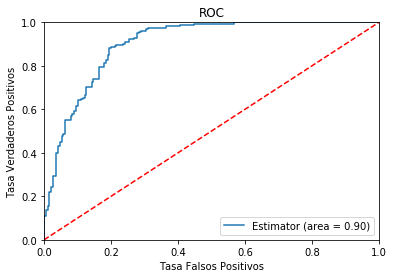

In [113]:
y_pred = clf.predict_proba(X_test)[:, 1]
plotPred(y_test,y_pred)

In [114]:
from sklearn.model_selection import cross_val_score

In [115]:
#clf.fit(X_train, y_train)
scores = cross_val_score(clf, XT, Y3, cv=5)
from sklearn.metrics import roc_curve, auc, roc_auc_score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, clf.predict(X_test))
print(auc(false_positive_rate, true_positive_rate))
print(roc_auc_score(y_test, clf.predict(X_test))) # 0,74 (0.53 sin undersampling, 0.78 con undersampling)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])) # 0,83 (0.88 sin undersampling, 0.87 con undersampling)
print(clf.score(X_test, y_test)) #0,76 (0.947 sin undersampling, 0.80 con undersampling

0.835064011379801
0.835064011379801
0.9027311522048364
0.8346666666666667


---
# Fit Modelo

In [116]:
clf.fit(XT,Y3)

VotingClassifier(estimators=[('XG', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.8, gamma=0, learning_rate=0.06, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', r...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[3, 2])

In [117]:
sortScores(X,clf.named_estimators_["XG"].feature_importances_).head(20)

0                                          1
199  0.047348                                        sku
181  0.040189                           model_mean_label
50   0.032053                         (total_time, mean)
48   0.028040                          (total_time, max)
49   0.025925                          (total_time, min)
164  0.025870                            duracion_sesion
157  0.025708                    max_visited_site_region
162  0.025111           max_visited_site_browser_version
161  0.023593  max_visited_site_operating_system_version
169  0.022833                     hours_since_last_event
2    0.022779                    (ad campaign hit, mean)
146  0.022020                         max_checkout_model
166  0.021911                    hours_since_first_event
26   0.021911                     (viewed product, mean)
14   0.021206                  (search engine hit, mean)
160  0.018983         max_visited_site_screen_resolution
171  0.018277                     count_events_last_week
170  0.018277                   minutes_since_last_event
51   0.018115                          (total_time, sum)
34   0.017464                    (generic listing, mean)

In [118]:
sortScores(X,clf.named_estimators_["RN"].feature_importances_).head(20)

0                          1
126  0.037955      checkout_from_week_20
127  0.034884      checkout_from_week_19
128  0.026523      checkout_from_week_18
146  0.024947         max_checkout_model
119  0.020951      checkout_from_month_5
129  0.016879      checkout_from_week_17
51   0.016777          (total_time, sum)
120  0.016158      checkout_from_month_4
149  0.016084         max_checkout_color
181  0.014930           model_mean_label
163  0.014247               cant_eventos
130  0.013788      checkout_from_week_16
170  0.013110   minutes_since_last_event
48   0.013078          (total_time, max)
183  0.012690    delta_s_from_last_event
169  0.012657     hours_since_last_event
199  0.011678                        sku
131  0.011606      checkout_from_week_15
132  0.011304      checkout_from_week_14
167  0.011296  minutes_since_first_event

In [119]:
#XCOL = pd.DataFrame(XT, columns=X.columns)

In [120]:
#xx = xgboost.XGBClassifier(max_depth=30,n_estimators=220, subsample=1, learning_rate=0.16, colsample_bylevel=0.7, colsample_bytree=0.8).fit(XCOL, Y3)

In [121]:
#xgboost.plot_importance(xx, max_num_features=15)

In [122]:
XtT = ss.transform(xtest)

/home/juan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int8, int64, float64, object were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [123]:
xtest.shape

(19415, 201)

In [124]:
y_pred_prob = clf.predict_proba(XtT)

In [125]:
y_pred_prob

array([[0.99118157, 0.00881844],
       [0.78622623, 0.21377378],
       [0.96038161, 0.0396184 ],
       ...,
       [0.78352484, 0.21647518],
       [0.40497548, 0.59502452],
       [0.41407569, 0.58592431]])

In [126]:
# Version para el predict_proba
predictionsDf = pd.DataFrame(y_pred_prob)
predictionsDf = predictionsDf[1]
predictionsDf = pd.DataFrame(predictionsDf)
predictionsDf.columns = ['label']
predictionsDf.head(3)

label
0  0.008818
1  0.213774
2  0.039618

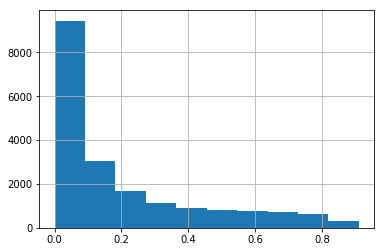

In [131]:
(predictionsDf['label']).hist()

In [128]:
xtestInd = xtest.index

In [129]:
per = pd.DataFrame(xtestInd).join(predictionsDf).set_index("person")

In [130]:
per.to_csv('submit.csv')